In [1]:
import torch 
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

LEARNING_RATE = 2e-4
BATCH_SIZE = 32
FEATURES_DISC = 64
FEATURES_GEN = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 20

array_transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Resize(IMAGE_SIZE),
                                torchvision.transforms.Lambda(lambda x : (x/255.)*2 - 1),
                                #torchvision.transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
])

train_data_addr = "E:/Hamavar/GenerativeAI/GAN/MNIST_CSV/mnist_train.csv"

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(Disc_Block(features_d, features_d*2, 4, 2, 1))
        self.layers.append(Disc_Block(features_d*2, features_d*4, 4, 2, 1))
        self.layers.append(Disc_Block(features_d*4, features_d*8, 4, 2, 1))
        self.layers.append(nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0))
        self.layers.append(nn.Sigmoid())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x


class Disc_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
                                    stride=stride, padding=padding, bias=False))
        self.layers.append(nn.LeakyReLU(0.2))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(Gen_Block(z_dim, features_g*16, 4, 1, 0))
        self.layers.append(Gen_Block(features_g*16, features_g*8, 4, 2, 1))
        self.layers.append(Gen_Block(features_g*8, features_g*4, 4, 2, 1))
        self.layers.append(Gen_Block(features_g*4, features_g*2, 4, 2, 1))
        self.layers.append(nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1))
        self.layers.append(nn.Tanh())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x


class Gen_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                                stride=stride, padding=padding, bias=False))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

class MNIST_Dataset(torch.utils.data.Dataset):
    def __init__(self, files_addr, transforms):
        super().__init__()
        self.samples = pd.read_csv(files_addr, header=None)
        self.transforms = transforms

    
    def __getitem__(self, index):
        data = np.array(self.samples.iloc[index][1:], dtype=np.float32).reshape((28, 28 ,1))
        data = self.transforms(data)
        label = np.array(self.samples.iloc[index][0])
        return data, label 

    def __len__(self):
        return len(self.samples)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def save_results(images, addr):
    images = images.detach().cpu().numpy()
    for image_index in range(images.shape[0]):
        plt.subplot(4, 8, image_index+1)
        plt.axis("off")
        plt.imshow(images[image_index].reshape(64, 64, 1), cmap="gray")

    plt.savefig(addr, dpi=600)


def show_results(images):
    images = images.detach().cpu().numpy()
    for image_index in range(images.shape[0]):
        plt.subplot(4, 8, image_index+1)
        plt.axis("off")
        plt.imshow(images[image_index].reshape(64, 64, 1), cmap="gray")

    plt.show()


In [4]:
dataset = MNIST_Dataset(files_addr=train_data_addr, transforms=array_transforms)
mnist_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

disc_model = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
generator_model = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

initialize_weights(disc_model)
initialize_weights(generator_model)

opt_disc = torch.optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(generator_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)



a:\Hamavar\CV_env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch : 0, Disc Loss : 0.5117326974868774, Gen Loss : 1.792993187904358
Epoch : 1, Disc Loss : 0.6311100125312805, Gen Loss : 0.97979336977005
Epoch : 2, Disc Loss : 0.557904839515686, Gen Loss : 1.2644282579421997
Epoch : 3, Disc Loss : 0.4555453062057495, Gen Loss : 1.7655597925186157
Epoch : 4, Disc Loss : 0.38538771867752075, Gen Loss : 2.1676416397094727
Epoch : 5, Disc Loss : 0.33108678460121155, Gen Loss : 2.563218832015991
Epoch : 6, Disc Loss : 0.2810562551021576, Gen Loss : 2.960261821746826
Epoch : 7, Disc Loss : 0.24210824072360992, Gen Loss : 3.3866336345672607
Epoch : 8, Disc Loss : 0.2477841079235077, Gen Loss : 3.343317747116089
Epoch : 9, Disc Loss : 0.21394871175289154, Gen Loss : 3.6927363872528076
Epoch : 10, Disc Loss : 0.19761960208415985, Gen Loss : 3.9163336753845215
Epoch : 11, Disc Loss : 0.18217402696609497, Gen Loss : 4.101442813873291
Epoch : 12, Disc Loss : 0.1917656511068344, Gen Loss : 4.0486907958984375
Epoch : 13, Disc Loss : 0.15792223811149597, Gen L

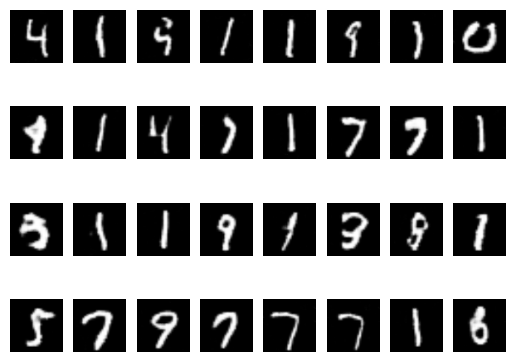

In [5]:
mean_of_disc_loss = list()
mean_of_gen_loss = list()

for epoch in range(NUM_EPOCHS):
    epoch_mean_of_disc_loss = list()
    epoch_mean_of_gen_loss = list()

    for real, _ in mnist_dataloader:
        real = real.to(device)

        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = generator_model(noise)

        disc_real = disc_model(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc_model(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake)/2

        disc_model.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        output = disc_model(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        generator_model.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        epoch_mean_of_disc_loss.append(loss_disc.detach().cpu())
        epoch_mean_of_gen_loss.append(loss_gen.detach().cpu())

    mean_of_disc_loss.append(np.mean(epoch_mean_of_disc_loss))
    mean_of_gen_loss.append(np.mean(epoch_mean_of_gen_loss))


    print(f"Epoch : {epoch}, Disc Loss : {mean_of_disc_loss[-1]}, Gen Loss : {mean_of_gen_loss[-1]}")

    with torch.no_grad():
        output = generator_model(fixed_noise)
        save_results(output, f"E:/Hamavar/GenerativeAI/GAN/DCGAN/results/generated_numbers/epoch_{epoch}.png")
        torch.save(generator_model.state_dict(), f"E:/Hamavar/GenerativeAI/GAN/DCGAN/results/models/epoch_{epoch}.pt")

    
        


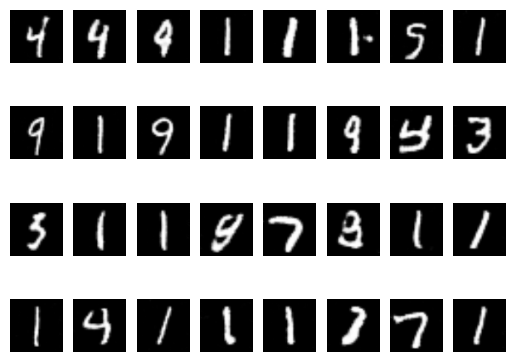

In [21]:
noise = torch.randn(32, Z_DIM, 1, 1).to(device)
output = generator_model(noise)
show_results(output)